In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import torch
from torch import nn

from models.embedding import SphericalGraphCNN

## Test embedding net

In [4]:
nside_list = [128, 64, 32, 16, 8, 4, 2]

In [5]:
from utils import create_mask as cm

hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.ud_grade(hp_mask_nside1, nside)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])

In [6]:
ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
hp_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2,
                              mask_ring = True, inner = 0, outer = 25, custom_mask=ps_mask)
hp_mask

array([ True,  True,  True, ...,  True,  True,  True])

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Test data generation

In [8]:
from models.scd import dnds
from utils.psf_correction import PSFCorrection
from models.psf import KingPSF

In [9]:
kp = KingPSF()

pc_inst = PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: kp.psf_fermi_r(r)

In [10]:
from simulations.wrapper import simulator

In [11]:
import sys
from sbi import utils
from sbi import inference

In [12]:
from utils.templates import get_NFW2_template

In [32]:
# Load templates
temp_gce = np.load("../data/fermi_data/template_gce.npy")  # get_NFW2_template(gamma=1.2)
temp_dif = np.load("../data/fermi_data/template_dif.npy")
temp_psc = np.load("../data/fermi_data/template_psc.npy")
temp_iso = np.load("../data/fermi_data/template_iso.npy")
temp_dsk = np.load("../data/fermi_data/template_dsk.npy")
temp_bub = np.load("../data/fermi_data/template_bub.npy")

temp_mO_pibrem = np.load('../data/fermi_data/ModelO_r25_q1_pibrem.npy')
temp_mO_ics = np.load('../data/fermi_data/ModelO_r25_q1_ics.npy')

temp_mA_pibrem = hp.ud_grade(np.load('../data/modelA/modelA_brempi0.npy'), nside_out=128, power=-2)
temp_mA_ics = hp.ud_grade(np.load('../data/modelA/modelA_ics.npy'), nside_out=128, power=-2)

fermi_exp = np.load("../data/fermi_data/fermidata_exposure.npy")

ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
roi_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25, custom_mask=ps_mask)
roi_mask_norm = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25)

## SNPE

In [72]:
hp.reorder(2 * [temp_mO_pibrem, temp_mO_ics], r2n=True)

array([[12.61743825, 11.53936085, 11.96339586, ..., 15.62852493,
        15.35732335, 17.22715047],
       [ 2.70702217,  2.62406866,  2.67150468, ...,  2.73865572,
         2.70040466,  2.78451869],
       [12.61743825, 11.53936085, 11.96339586, ..., 15.62852493,
        15.35732335, 17.22715047],
       [ 2.70702217,  2.62406866,  2.67150468, ...,  2.73865572,
         2.70040466,  2.78451869]])

In [83]:
sg_embed = SphericalGraphCNN(nside_list, indexes_list, n_neighbours=8, n_aux=2, n_params=0, laplacian_type="normalized", activation="relu").to(device)
sg_embed(get_signal_injection(0))

tensor([[0.0151, 0.0000, 0.0141, 0.0000, 0.0860, 0.0000, 0.0000, 0.1860, 0.0796,
         0.0846, 0.1450, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0782, 0.0000, 0.1641, 0.0000, 0.1208, 0.0224, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.1759, 0.0447, 0.2178, 0.0000, 0.0000, 0.2390,
         0.2962, 0.0000, 0.0249, 0.0000, 0.1327, 0.0098, 0.0571, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1496, 0.0000, 0.1858,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0891, 0.1348, 0.0926, 0.0644, 0.0000,
         0.0000, 0.2044, 0.0000, 0.0000, 0.0000, 0.0009, 0.0000, 0.1283, 0.0000,
         0.0000, 0.0000, 0.0139, 0.0632, 0.0000, 0.1237, 0.0000, 0.0000, 0.0000,
         0.1213, 0.0489, 0.0000, 0.0000, 0.1674, 0.1965, 0.0000, 0.0074, 0.0786,
         0.0000, 0.0573, 0.0000, 0.0000, 0.0000, 0.0485]],
       grad_fn=<SliceBackward>)

In [37]:
from sbi.inference import PosteriorEstimator
from sbi import utils
from sbi import inference

In [66]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [67]:
# iso, bub, psc, dif_pibrem, dif_ics
prior_poiss = [[0.001, 0.001, 0.001, 6., 1.], [1.5, 1.5, 1.5, 12., 6.]]

# gce, dsk
prior_ps = [[0.001, 10.0, 1.1, -10.0, 5.0, 0.1, 0.001, 10.0, 1.1, -10.0, 5.0, 0.1], [2., 20.0, 1.99, 1.99, 35.0, 4.99, 2., 20.0, 1.99, 1.99, 35.0, 4.99]]

# Combine priors
prior = utils.BoxUniform(low=torch.tensor([0.001] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([2.5] + prior_poiss[1] + prior_ps[1]))

In [68]:
from sbi import utils as utils

In [69]:
# instantiate the neural density estimator
neural_classifier = utils.posterior_nn(model='maf',
                                      embedding_net=sg_embed,
                                      hidden_features=50,
                                      num_transforms=4,
)

# setup the inference procedure with the SNPE-C procedure
inference_inst = PosteriorEstimator(prior=prior, density_estimator=neural_classifier, 
                           show_progress_bars=True,
                           logging_level='INFO',
                           device=device.type)

In [70]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [98]:
poiss_labels = [r"iso", r"bub", r"psc", r"pibrem", r"ics"]
ps_labels = [r"gce ps", r"dsk ps"]
temps_poiss = [temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
temps_ps = [temp_gce, temp_dsk]

In [14]:
def get_signal_injection(coeff, plot_map=False):
    in_map = np.load("../data/fermi_data/fermidata_counts.npy") + coeff * np.random.poisson(temp_gce)
    in_map[hp_mask] = 0
    
    if plot_map:
        hp.mollview(in_map, max=100)

    in_map = torch.Tensor(in_map[~masks_list[0]])
    in_map = in_map.reshape((1, -1, 1))

    log_mean = torch.log(torch.mean(in_map))
    log_std = torch.log(torch.var(in_map).sqrt())

    log_mean = log_mean.reshape((1, -1, 1))
    log_std = log_std.reshape((1, -1, 1))

    data_map = torch.cat([in_map, log_mean, log_std], axis=1)[:, :, 0]
    
    return data_map

In [100]:
temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
temps_ps_sim = [temp_gce, temp_dsk]

In [101]:
temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':temps_ps_sim,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':temps_poiss_sim,
 'poiss_labels':poiss_labels}

In [102]:
roi_normalize = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2, mask_ring = True, inner = 0, outer = 25)

In [103]:
from sbi.utils import x_shape_from_simulation

In [104]:
from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger
import mlflow

run_id = '19194be661ce497db700482d6d237ecc'
    
data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/mlruns/1/' + run_id + '/artifacts/density_estimator')

2021/03/26 13:48:36 WARNING mlflow.pytorch: Stored model version '1.7.0' does not match installed PyTorch version '1.6.0'


In [112]:
from utils.plotting import make_plot, make_signal_injection_plot
roi_sim = masks_list[0]

### Analysis on simulations

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


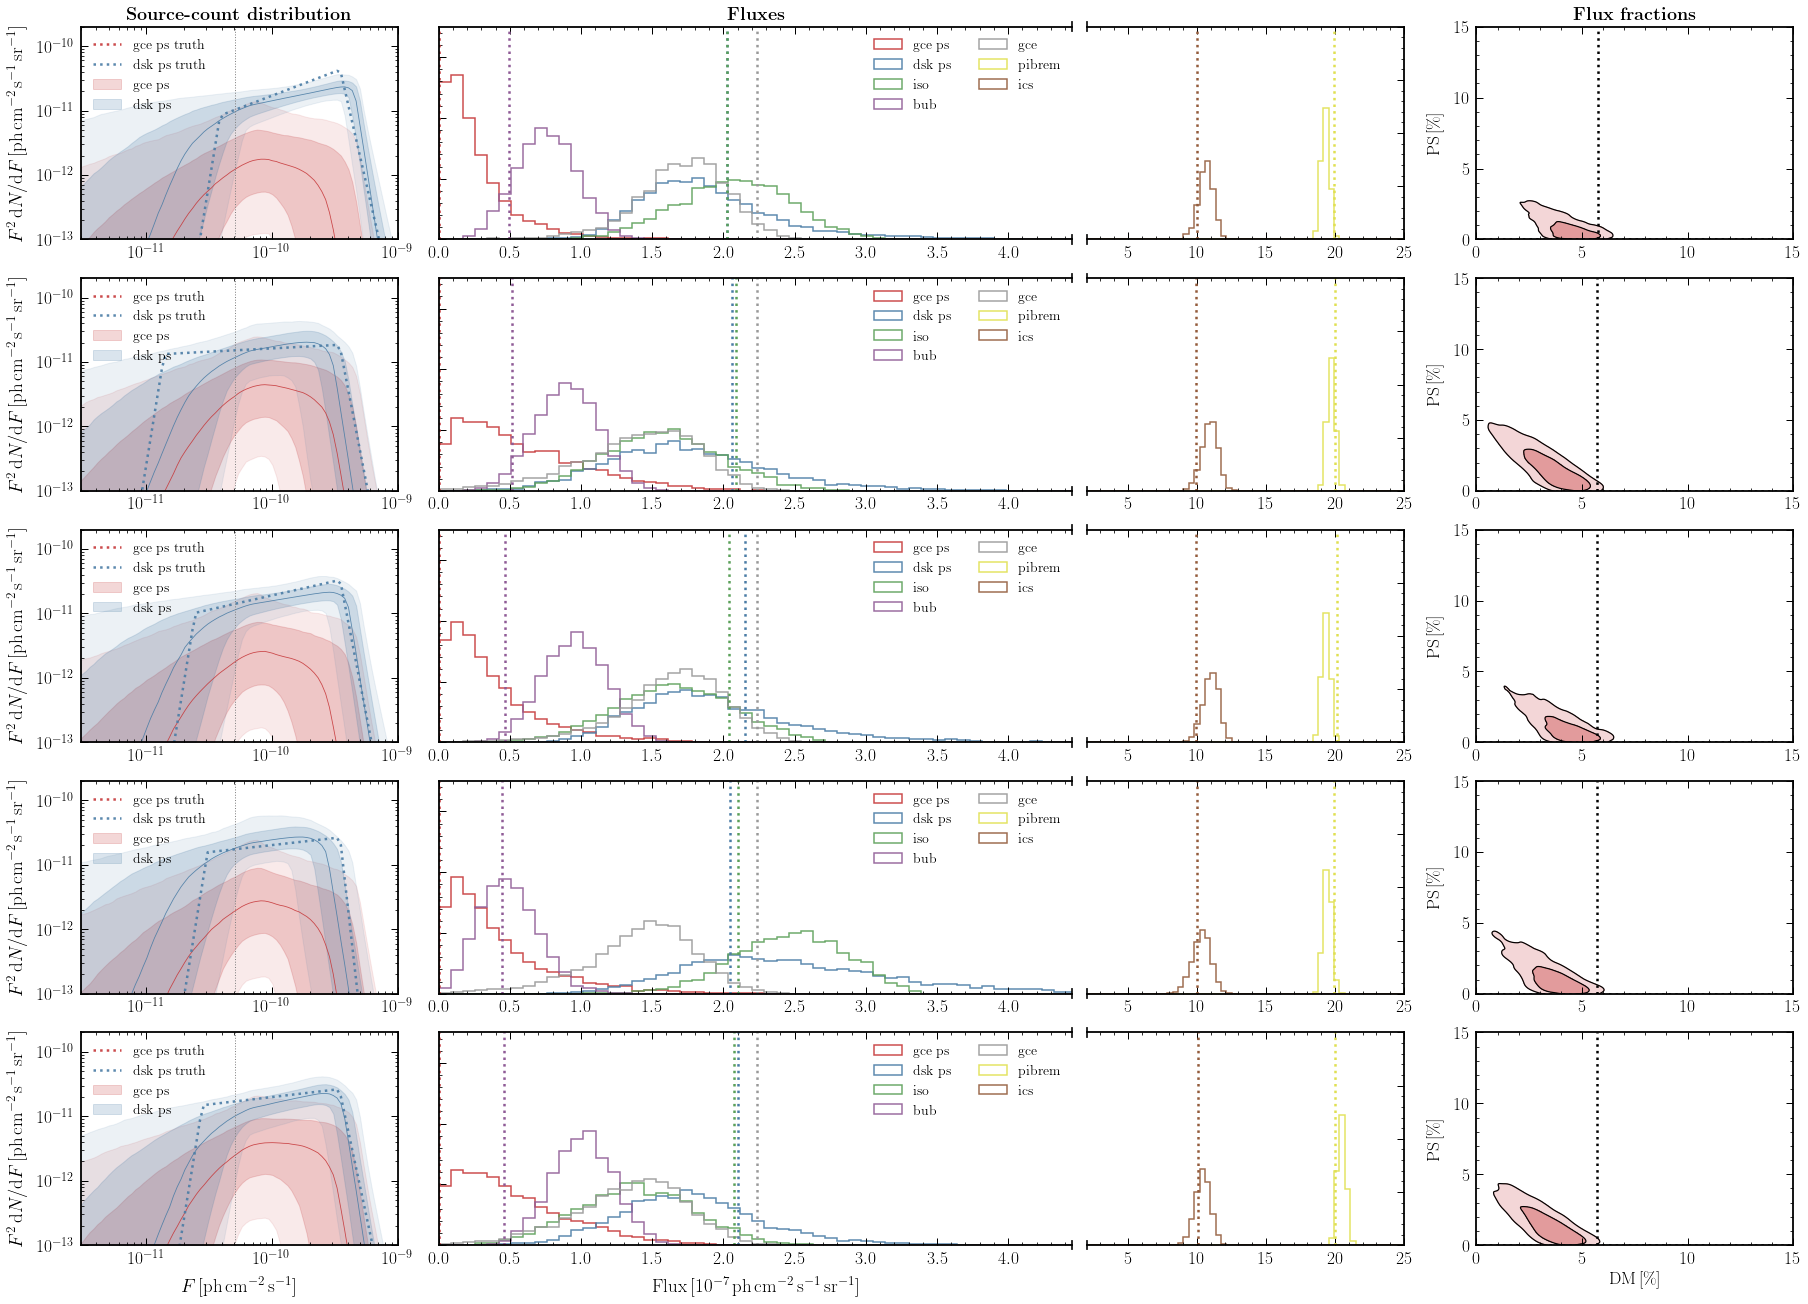

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [107]:
data_map = np.load("../data/samples/x_ModelO_DM_only.npy")[:5]
aux = np.load("../data/samples/x_aux_ModelO_DM_only.npy")[:5]
thetas = np.load("../data/samples/theta_ModelO_DM_only.npy")[:5]

x_presimulated = torch.Tensor(data_map)
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = (thetas)

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
posterior = inference_inst.build_posterior(density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, figsize=(25, 3.6 * 5), n_samples=5000, temps_dict=temps_dict, save_filename="../paper/plots/sim_sbi_dm.pdf") 

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


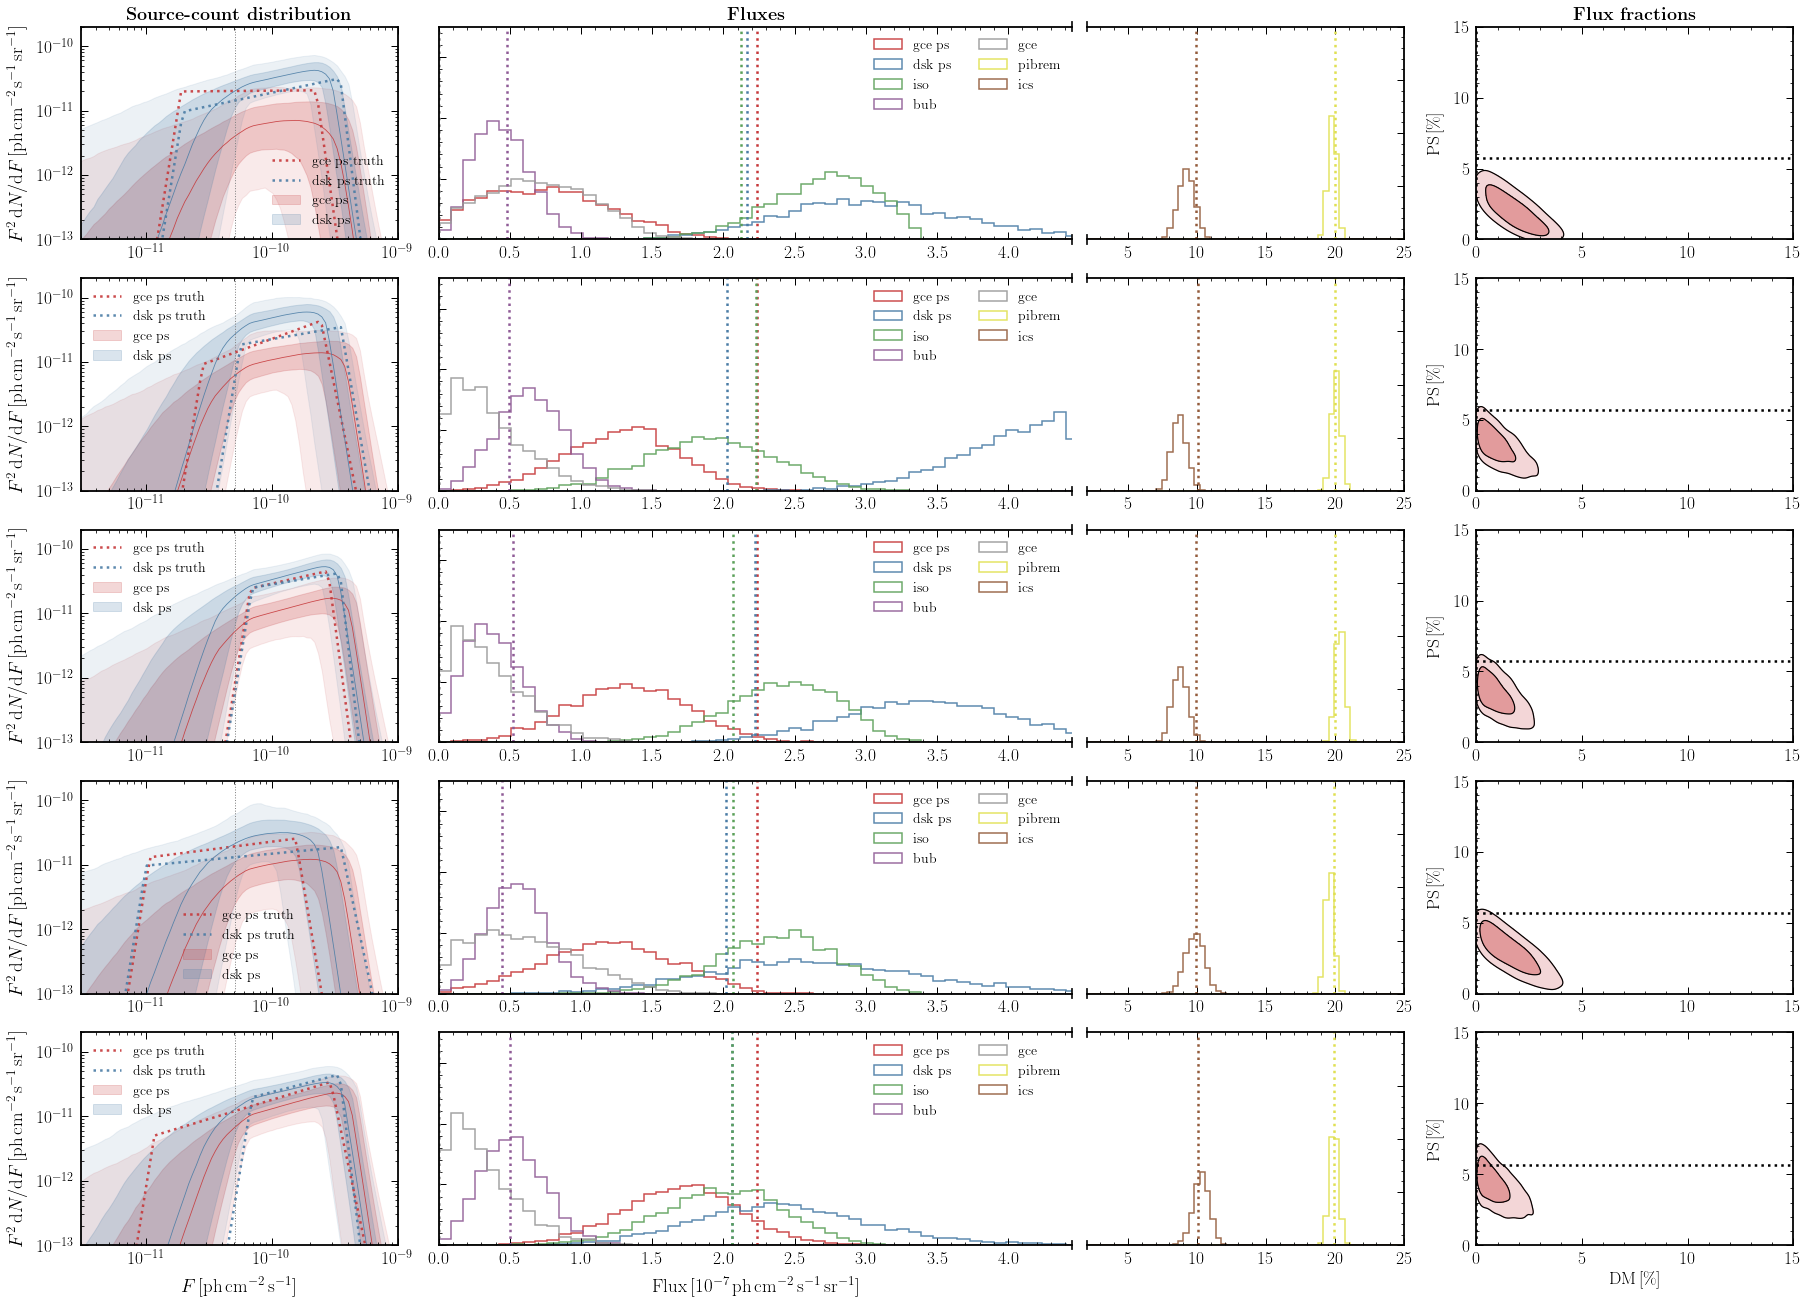

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [111]:
data_map = np.load("../data/samples/x_ModelO_PS_only.npy")[:5]
aux = np.load("../data/samples/x_aux_ModelO_PS_only.npy")[:5]
thetas = np.load("../data/samples/theta_ModelO_PS_only.npy")[:5]

x_presimulated = torch.Tensor(data_map)
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = (thetas)

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
posterior = inference_inst.build_posterior(density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, figsize=(25, 3.6 * 5), n_samples=5000, temps_dict=temps_dict, save_filename="../paper/plots/sim_sbi_ps.pdf") 

### Analysis on data

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

Removed no burn in


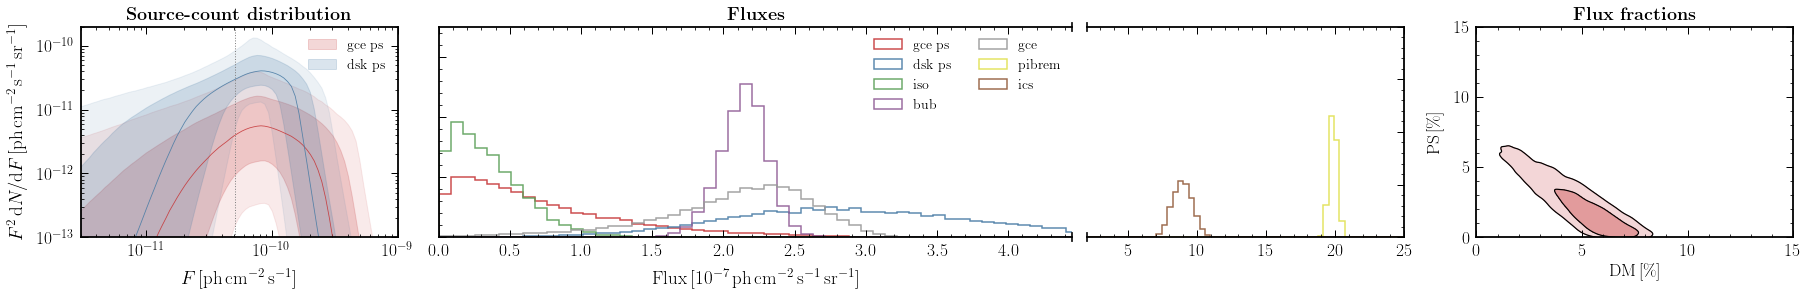

<Figure size 432x324 with 0 Axes>

In [110]:
coeff_ary = [0.]

x_test = torch.Tensor(np.array([get_signal_injection(coeff).detach().numpy() for coeff in coeff_ary]))
inference_inst.x_shape = x_shape_from_simulation(x_test)

posterior = inference_inst.build_posterior(density_estimator)

make_plot(posterior=posterior, x_test=x_test, theta_test=None, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, is_data=True, signal_injection=True, figsize=(25, 4), save_filename="../paper/plots/data_fid_sbi.pdf", n_samples=20000, temps_dict=temps_dict)

### Signal injection on data

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


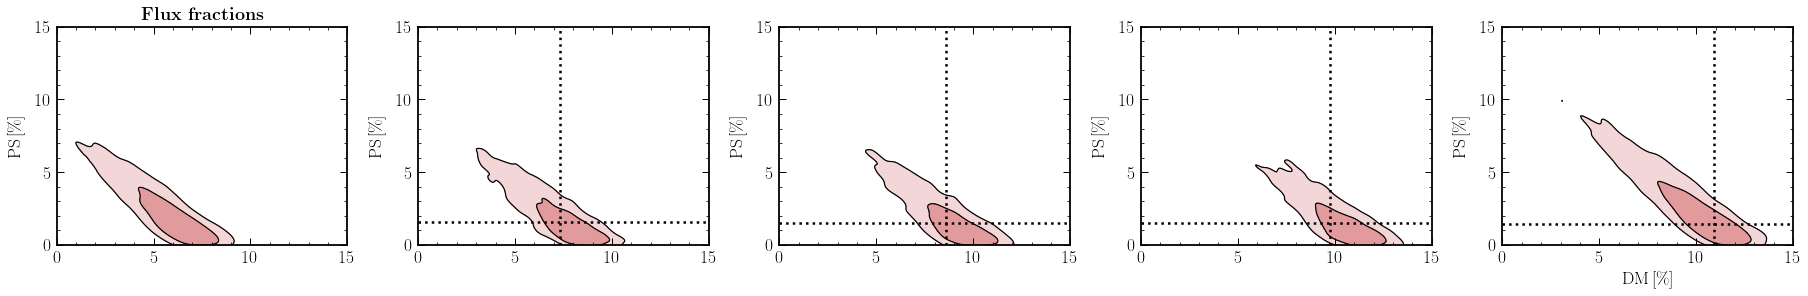

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [115]:
coeff_ary = np.linspace(0, 0.9, 5)
x_test = torch.Tensor(np.array([get_signal_injection(coeff).detach().numpy() for coeff in coeff_ary]))

inference_inst.x_shape = x_shape_from_simulation(x_test)
posterior = inference_inst.build_posterior(density_estimator)

make_signal_injection_plot(posterior=posterior, x_test=x_test, theta_test=None, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask, is_data=True, signal_injection=True, n_samples=5000, coeff_ary=coeff_ary, temps_dict=temps_dict, figsize=(25, 4), save_filename="../paper/plots/data_sig_inj.pdf")

### NPTF analysis on data

Removed no burn in


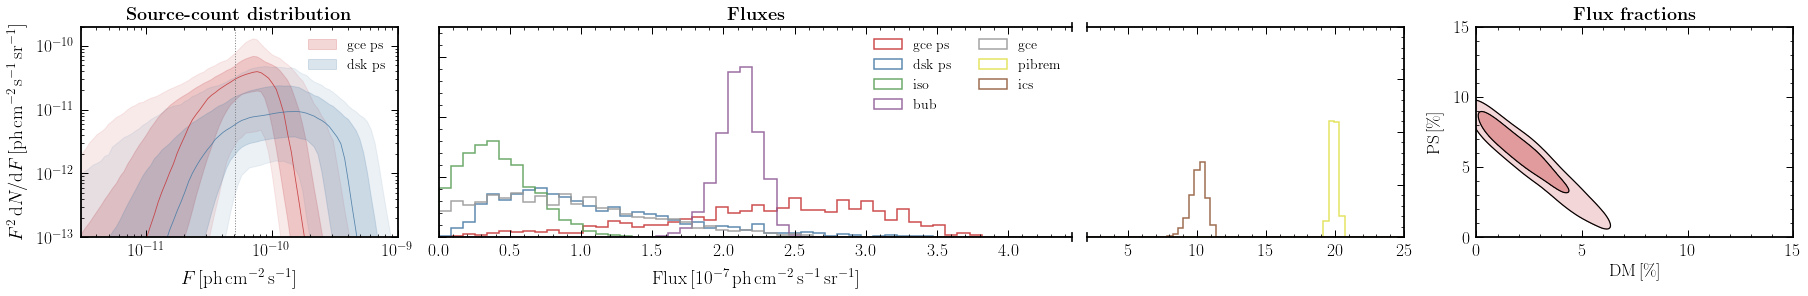

<Figure size 432x324 with 0 Axes>

In [96]:
samples_weighted = torch.Tensor(np.load("../data/nptfit_samples/fermi_data_-1_samples.npz")["samples_weighted"])
samples_weighted = torch.unsqueeze(samples_weighted, 0).detach().numpy()

fermi_data = torch.Tensor(np.array([get_signal_injection(coeff).detach().numpy()[:,:-2] for coeff in coeff_ary]))

roi_counts_normalize = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2, mask_ring = True, inner = 0, outer = 25)

fermi_data = fermi_data.detach().numpy()
make_plot(posterior=samples_weighted, x_test=fermi_data, x_data_test=fermi_data, theta_test=None, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, is_data=True, signal_injection=False, figsize=(25, 4), nptf=True, save_filename="../paper/plots/data_fid_nptf.pdf", temps_dict=temps_dict)

In [82]:
# samples_weighted = torch.Tensor(np.load("../data/nptfit_samples/fermi_data_-1_samples.npz")["samples_weighted"])
# samples_weighted = torch.unsqueeze(samples_weighted, 0)
# # thetas = np.load("../data/samples/theta_ModelO_PS_only.npy")[2:3]

# fermi_data = torch.Tensor(np.load("../data/samples/x_ModelO_PS_only.npy")[2:3])
# fermi_data = torch.unsqueeze(fermi_data, 0)
# theta_presimulated = torch.Tensor(thetas)

# roi_counts_normalize = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2, mask_ring = True, inner = 0, outer = 25)

# fermi_data = fermi_data.detach().numpy()
# make_plot(posterior=samples_weighted, x_test=fermi_data, x_data_test=fermi_data, theta_test=theta_presimulated, roi_normalize=roi_normalize, roi_counts_normalize=roi_counts_normalize, is_data=True, signal_injection=False, figsize=(25, 4), nptf=True, save_filename="../paper/plots/data_fid_nptf.pdf")

### Mismodeling

In [86]:
# iso, bub, psc, dif
prior_poiss = [[0.9, 0.18, 0.5, 9. / 8., 0.8], [1., 0.22, 0.55, 9.1 / 8., 0.83]]

# gce, dsk
prior_ps = [[1.0, 10.0, 1.1, -10.0, 20.0, 2., 0.001, 10.0, 1.1, -10.0, 24.0, 0.1], [1.1, 20.0, 1.99, -9.99, 25.0, 4.99, 1.0, 20.0, 1.99, -9.99, 25.0, 4.99]]

prior = utils.BoxUniform(low=torch.tensor([0.0] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([0.01] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((5,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mA_pibrem, temp_mA_ics]
temps_ps_sim = [temp_gce, temp_dsk]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func) for theta in tqdm_notebook(thetas)]

from operator import itemgetter
data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/5 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


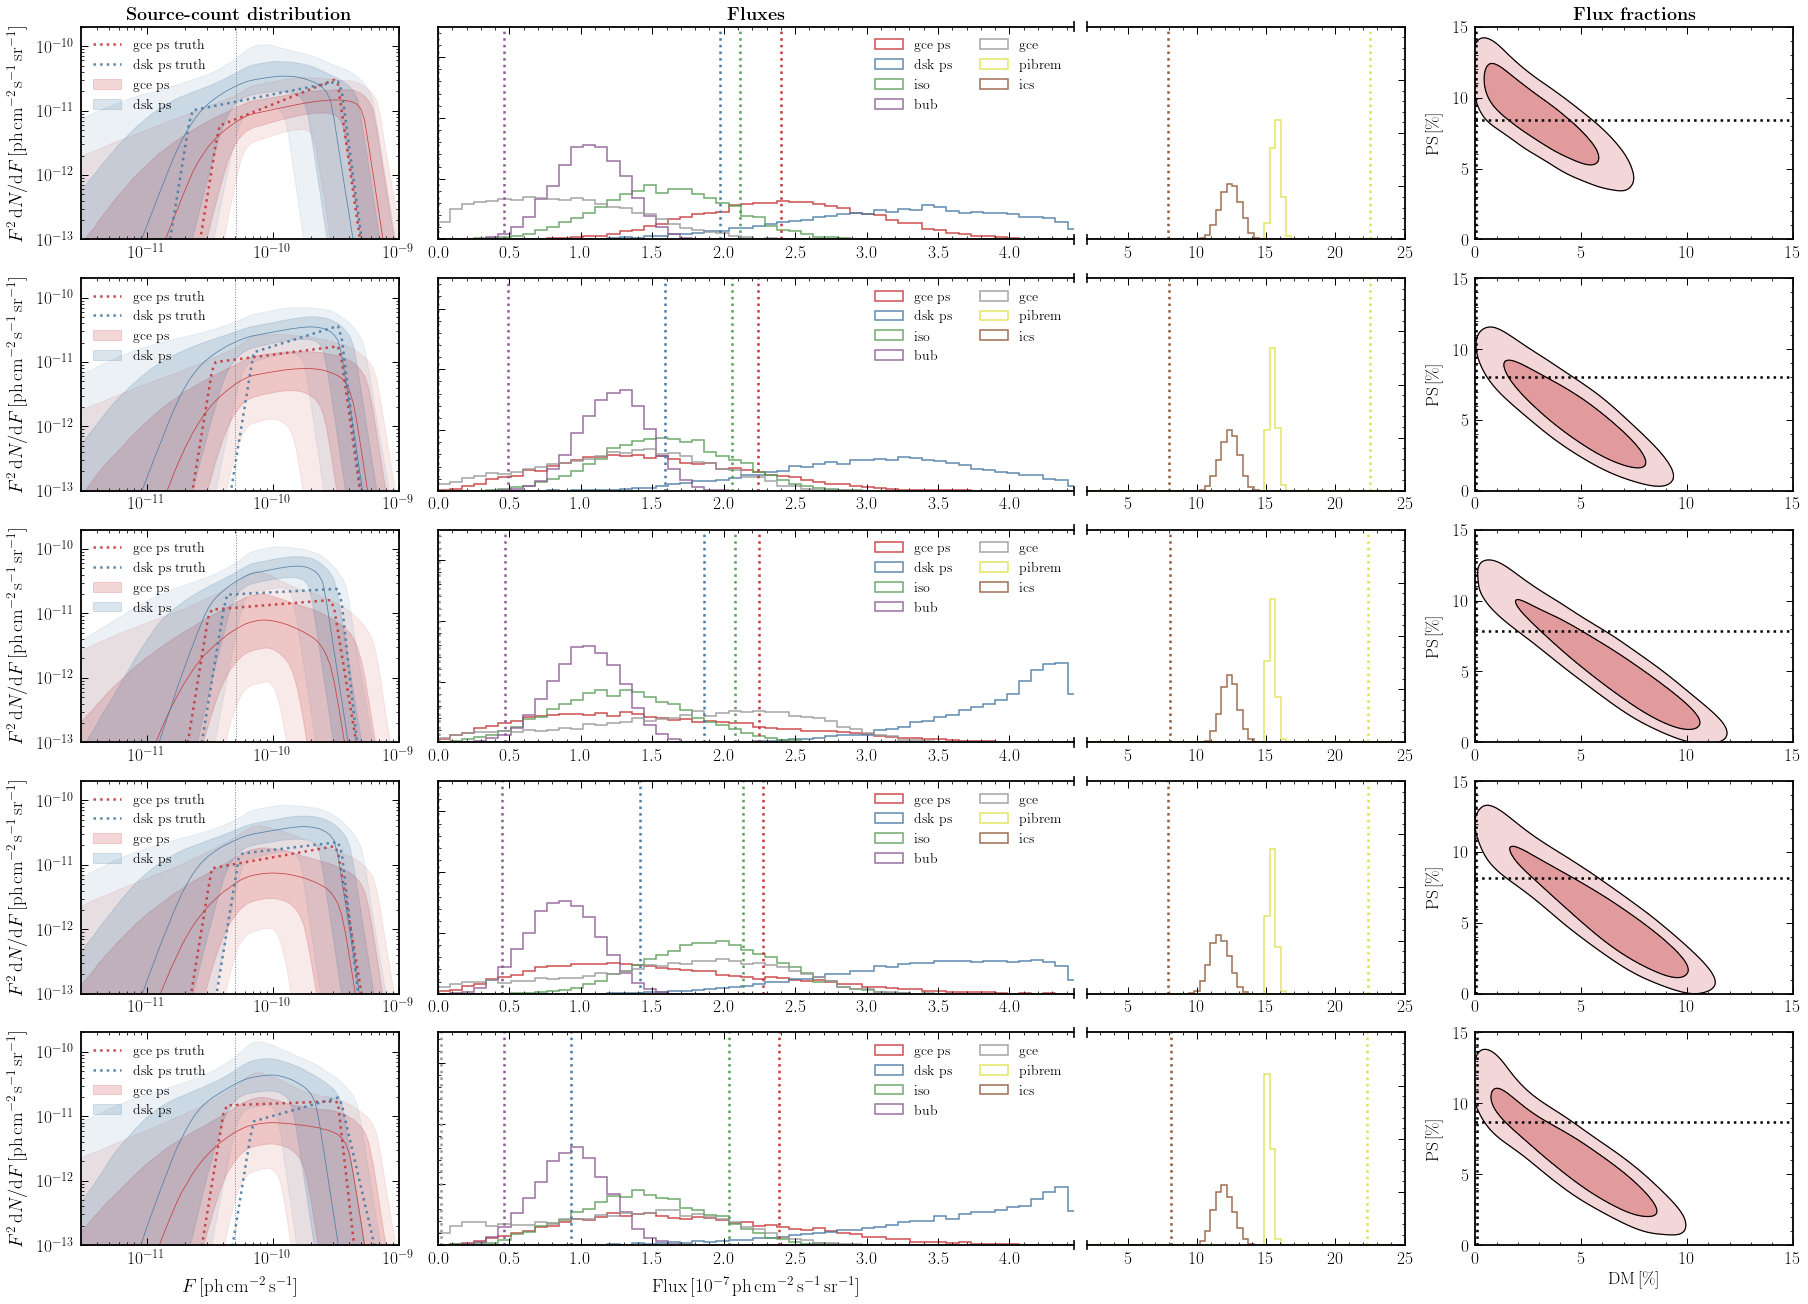

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [87]:
posterior = inference_inst.build_posterior(density_estimator)

x_presimulated = torch.Tensor(data_map)
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = torch.Tensor(thetas)


inference_inst.x_shape = x_shape_from_simulation(x_presimulated)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm)

## SNPE-PCA

In [1227]:
# instantiate the neural density estimator
neural_classifier = utils.posterior_nn(model='maf',
                                      embedding_net=nn.Identity(),
                                      hidden_features=50,
                                      num_transforms=4,
)

# setup the inference procedure with the SNPE-C procedure
inference_inst = PosteriorEstimator(prior=prior, density_estimator=neural_classifier, 
                           show_progress_bars=True,
                           logging_level='INFO',
                          device=device.type)

In [1228]:
run_id = '723f6e04b48b4238b63e1fc66c5b7644'
n_components = 24

data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/mlruns/0/' + run_id + '/artifacts/density_estimator')

2021/02/24 13:49:28 WARNING mlflow.pytorch: Stored model version '1.7.0' does not match installed PyTorch version '1.6.0'


In [1229]:
import joblib
from sklearn.decomposition import PCA, IncrementalPCA

pca_model = joblib.load("../data/models/pca_96_train_ModelO_gamma_fix.p")

/Users/smsharma/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator IncrementalPCA from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [1230]:
x_data_presimulated = torch.Tensor(data_map)
x_presimulated = torch.Tensor([pca_model.transform(in_map)[:,:n_components] for in_map in x_data_presimulated])
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = torch.Tensor(thetas)

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)

In [1231]:
posterior = inference_inst.build_posterior(density_estimator)

(1.0, 96.0)

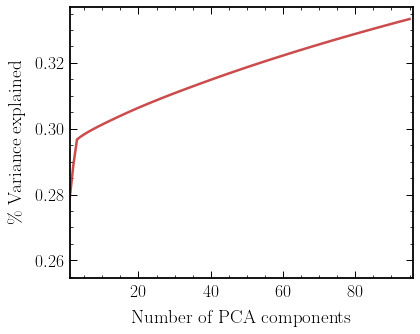

In [1232]:
plt.plot(np.arange(96), np.cumsum(pca_model.explained_variance_ratio_))
plt.xlabel("Number of PCA components")
plt.ylabel("\% Variance explained")
plt.xlim(1, 96)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


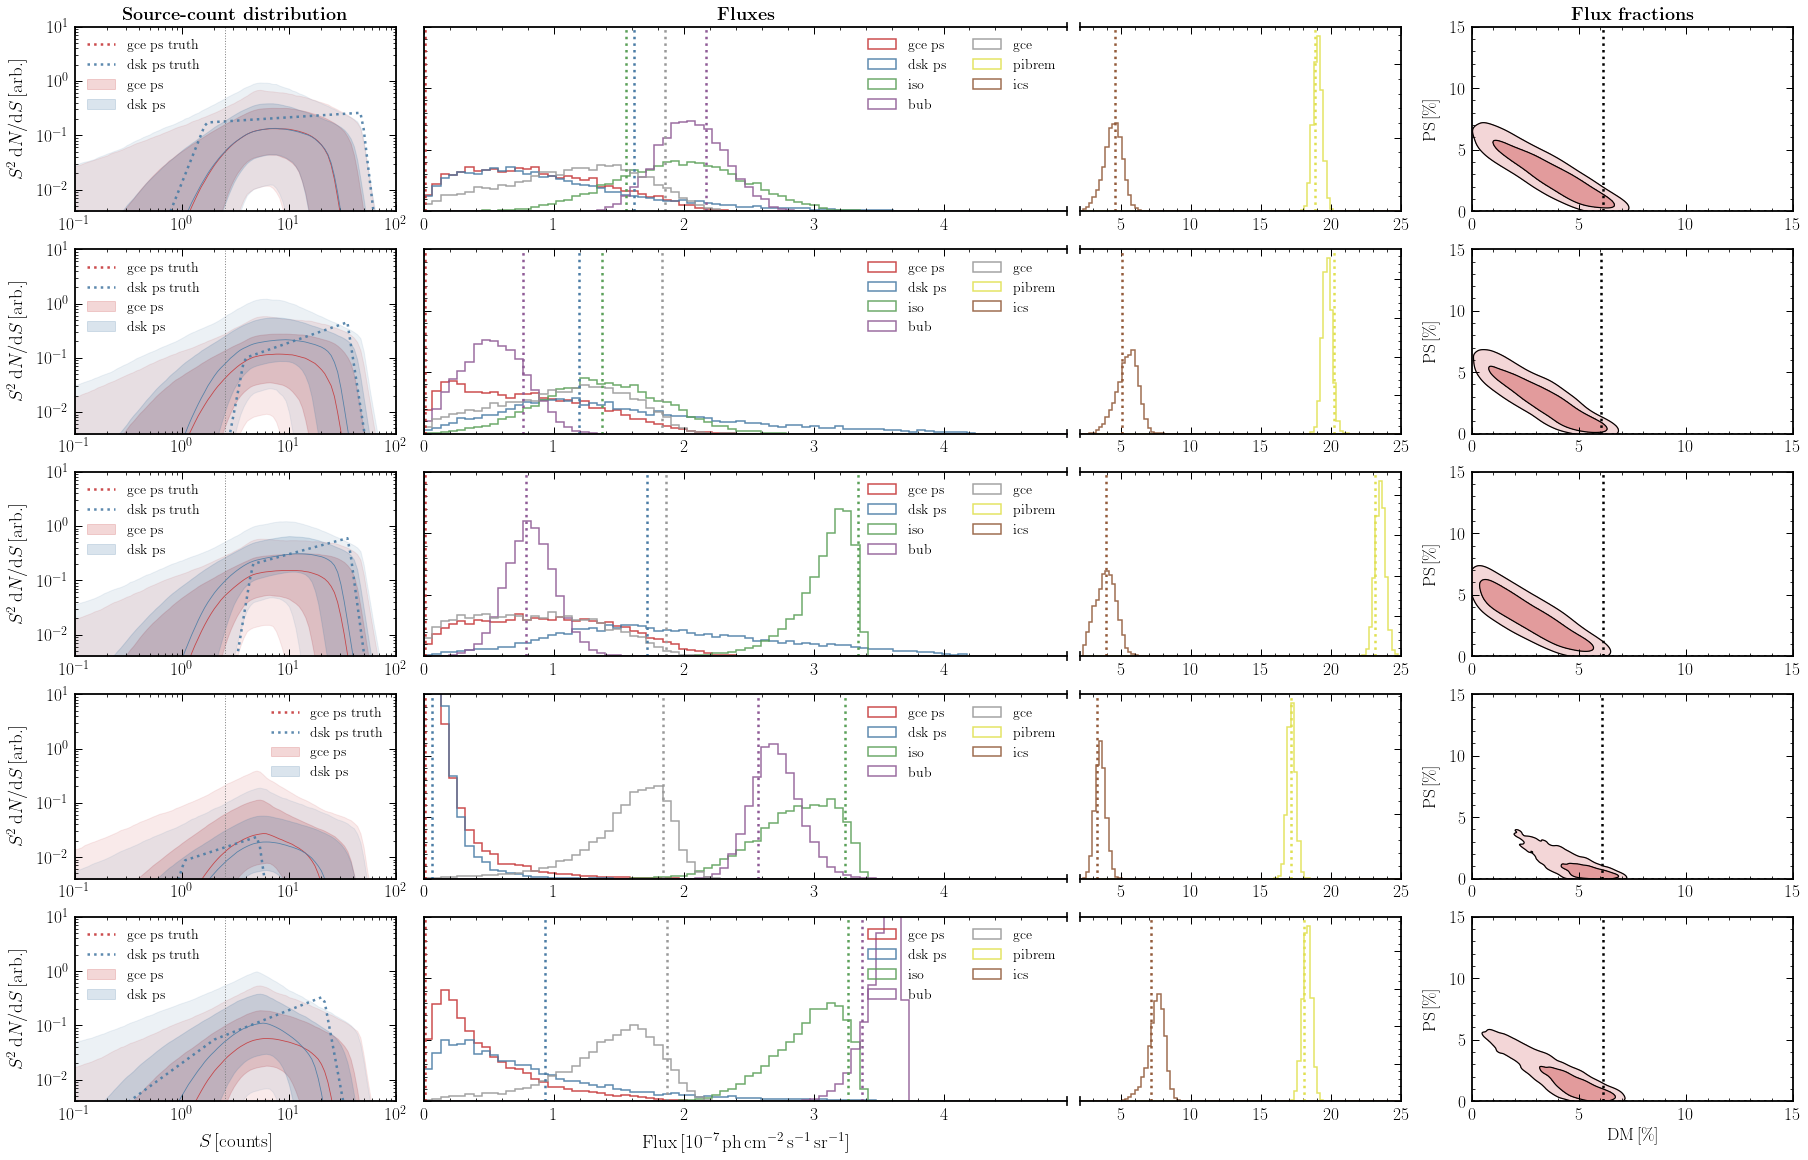

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [1233]:
x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

make_plot(posterior=posterior, x_test=x_test, x_data_test=x_data_presimulated, theta_test=theta_test)

In [1234]:
def get_signal_injection_pca(coeff, plot_map=False, n_components=96):
    in_map = np.load("../data/fermi_data/fermidata_counts.npy") + coeff * np.random.poisson(temp_gce)
    in_map[hp_mask] = 0
    
    if plot_map:
        hp.mollview(in_map, max=100)

    in_map = torch.Tensor(in_map[~masks_list[0]])
    in_map = in_map.reshape((1, -1, 1))

    log_mean = torch.log(torch.mean(in_map))
    log_std = torch.log(torch.var(in_map).sqrt())

    in_map = torch.Tensor(pca_model.transform(in_map[:,:,0]))[:,:n_components]
    
    log_mean = log_mean.reshape((1, -1))
    log_std = log_std.reshape((1, -1))
    
    data_map = torch.cat([in_map, log_mean, log_std], axis=1)
    
    return data_map

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


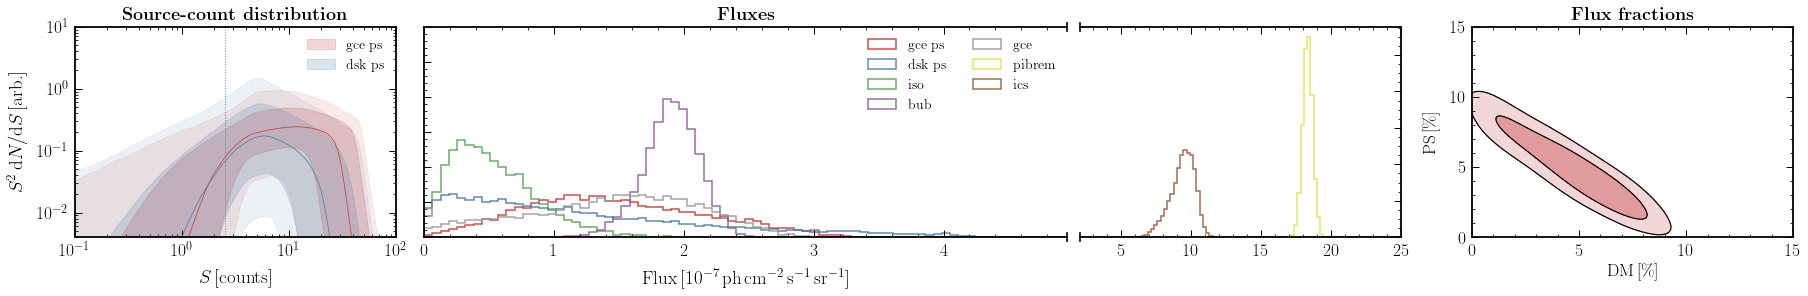

<Figure size 432x324 with 0 Axes>

In [1235]:
coeff_ary = [0.]
x_test = torch.Tensor(np.array([get_signal_injection_pca(coeff, n_components=n_components).detach().numpy() for coeff in coeff_ary]))
make_plot(posterior=posterior, x_test=x_test, x_data_test=x_data_presimulated, theta_test=theta_test, is_data=True, signal_injection=True, figsize=(25, 4))

## SNRE

In [39]:
sys.path.append("../")
sys.path.append(".")
sys.path.append("../sbi/")

from sbi.inference import RatioEstimator

sg_embed = SphericalGraphCNN(nside_list, indexes_list, n_aux=2, n_params=2).to(device)

# Instantiate the neural density estimator
neural_classifier = utils.classifier_nn(model="mlp_mixed", embedding_net_x=sg_embed)

# Setup the inference procedure with NPE
posterior_estimator = RatioEstimator(prior=prior, classifier=neural_classifier, show_progress_bars=True, logging_level="INFO")

In [40]:
run_id = '0f36ee019e6448c788b43c8a18e39abf'

data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/mlruns/2/' + run_id + '/artifacts/density_estimator')

2021/03/26 12:56:30 WARNING mlflow.pytorch: Stored model version '1.7.0' does not match installed PyTorch version '1.6.0'


In [41]:
posterior = posterior_estimator.build_posterior(density_estimator)
posterior_estimator.x_shape = x_shape_from_simulation(x_presimulated)

In [44]:
x_test = torch.Tensor(np.array([get_signal_injection(coeff).detach().numpy() for coeff in coeff_ary]))

In [45]:
truth_idx = 0
x_o = x_test
posterior_samples = posterior.sample([50], x=x_o, sample_with_mcmc=True, mcmc_method="nuts")

Sample: 100%|██████████| 521/521 [03:04,  2.82it/s, step size=7.97e-01, acc. prob=0.273]


In [108]:
np.transpose([np.mean(posterior_samples.detach().numpy(), axis=0), theta_presimulated[0].detach().numpy()])

array([[ 1.2654042 ,  0.9381074 ],
       [ 0.6119688 ,  1.0152464 ],
       [ 1.0364982 ,  0.8255643 ],
       [ 0.95088965,  0.7791615 ],
       [ 7.6009755 ,  8.794834  ],
       [ 2.5160046 ,  1.6621089 ],
       [ 0.34260735,  0.8963742 ],
       [14.802166  , 13.866877  ],
       [ 1.4710561 ,  1.4423819 ],
       [-4.483611  , -8.074902  ],
       [24.654509  ,  5.536254  ],
       [ 4.3863845 ,  4.7412066 ],
       [ 0.9101762 ,  1.8060533 ],
       [18.175697  , 15.529869  ],
       [ 1.5949386 ,  1.3168153 ],
       [-6.2692018 , -4.2470574 ],
       [48.65707   , 21.255575  ],
       [ 4.431909  ,  0.42830312]], dtype=float32)

In [59]:
# fermi_data = np.load("../data/fermi_data/fermidata_counts.npy")
# make_plot(posterior=posterior_samples.detach().numpy(), x_test=fermi_data, x_data_test=fermi_data, theta_test=theta_presimulated, roi_normalize=roi_normalize, roi_counts_normalize=roi_normalize, is_data=True, signal_injection=False, figsize=(25, 4), nptf=True, temps_dict=temps_dict)